# Representación de puntos de recarga de vehículo eléctrico en Cataluña

En este documento de código se describe la generación de un mapa de puntos de recarga de vehículo eléctrico en Cataluña, a partir de los datos disponibles en el portal de datos abiertos del gobierno de España

## 1. Carga de librerías y ficheros de entrada

Se procede a cargar las librerías necesarias así como el fichero de datos.

In [2]:
!pip install geopandas
!pip install shapely
!pip install geoplot
!pip install folium

In [3]:
import geopandas as gpd
import descartes
import pandas as pd
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon
import geoplot
import folium
from folium.plugins import HeatMap
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir("drive/My Drive")
df_grafo_desc_fin = pd.read_csv('df_grafo_desc_fin.csv',delimiter=",")

In [6]:
df_grafo_desc_fin

,punto_ini,denom_ini,tipo_carg_ini,provincia_ini,municipio_ini,tipo_vehic_ini,punto_fin,denom_fin,tipo_carg_fin,provincia_fin,municipio_fin,tipo_vehic_fin,distancia,duracion,lat_ini,lon_ini,lat_fin,lon_fin
0,"(41.321165, 2.027702)",CC ALDI,NORMAL,Barcelona,Viladecans,cotxe,"(40.80762, 0.52007)",EdRsR Tortosa (AC22kW) PIRVEC-24,semiRAPID,Tarragona,Tortosa,NaN,164.0,6091,41.321165,2.027702,40.807620,0.520070
1,"(41.321165, 2.027702)",CC ALDI,NORMAL,Barcelona,Viladecans,cotxe,"(41.38455, 2.1376713)",HOTEL NH NUMANCIA,NORMAL,Barcelona,Barcelona,NaN,15.1,1150,41.321165,2.027702,41.384550,2.137671
2,"(41.321165, 2.027702)",CC ALDI,NORMAL,Barcelona,Viladecans,cotxe,"(41.394009000000004, 2.115265)",B:SM 20 - Marques de Mulhacen,NORMAL,Barcelona,Barcelona,cotxe i moto,13.8,933,41.321165,2.027702,41.394009,2.115265
3,"(41.321165, 2.027702)",CC ALDI,NORMAL,Barcelona,Viladecans,cotxe,"(41.4047, 2.1896)",B:SM 24 - Ona Glòries,NORMAL,Barcelona,Barcelona,cotxe,22.5,1644,41.321165,2.027702,41.404700,2.189600
4,"(41.321165, 2.027702)",CC ALDI,NORMAL,Barcelona,Viladecans,cotxe,"(41.66519, 1.86011)",EdRsR Sant Vicenç de Castellet (AC22kW),semiRAPID,Barcelona,Sant Vicenç de Castellet,NaN,52.1,2512,41.321165,2.027702,41.665190,1.860110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70493,"(42.426809999999996, 1.9292200000000002)",EdRR Puigcerdà (DC50kW AC43kW) PIRVEC-20,RAPID,Girona,Puigcerdà,NaN,"(41.372299, 2.153134)",B:SM 35 - Rius i Taulet,NORMAL,Barcelona,Barcelona,cotxe i moto,151.0,6972,42.426810,1.929220,41.372299,2.153134
70494,"(42.426809999999996, 1.9292200000000002)",EdRR Puigcerdà (DC50kW AC43kW) PIRVEC-20,RAPID,Girona,Puigcerdà,NaN,"(41.56064, 2.0059)",Aparcament Plaça Progrés,NORMAL,Barcelona,Terrassa,cotxe i moto,124.0,5497,42.426810,1.929220,41.560640,2.005900
70495,"(41.613690000000005, 2.3454900000000003)",CC La Roca Village Aparcament (11kW),semiRAPID i NORMAL,Barcelona,La Roca del Vallès,cotxe i moto,"(41.372299, 2.153134)",B:SM 35 - Rius i Taulet,NORMAL,Barcelona,Barcelona,cotxe i moto,52.0,2635,41.613690,2.345490,41.372299,2.153134
70496,"(41.613690000000005, 2.3454900000000003)",CC La Roca Village Aparcament (11kW),semiRAPID i NORMAL,Barcelona,La Roca del Vallès,cotxe i moto,"(41.56064, 2.0059)",Aparcament Plaça Progrés,NORMAL,Barcelona,Terrassa,cotxe i moto,40.8,1960,41.613690,2.345490,41.560640,2.005900


## 2. Representación de mapa de puntos de carga

A continuación se representarán los puntos de recarga en Cataluña sobre un mapa de la comunidad autónoma, a partir de las coordenadas geográficas. Se hará uso de un fichero .shp disponible en un repositorio oficial del departamento de políticas digitales y territorio de la Generalitat de Cataluña. Se utilizarán las funciones disponibles en la librería Geopandas. Fuente: https://territori.gencat.cat/ca/06_territori_i_urbanisme/observatori_territori/mapa_urbanistic_de_catalunya/serveis_web_i_dades_obertes/descarrega-de-dades/format-shapefile-shp/

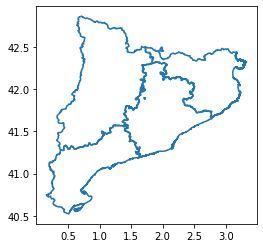

In [7]:
cat_map = gpd.read_file('geo_export_d6323c5f-e16e-42fc-a65a-2fb10a8a9015.shp')
cat_map.to_crs(epsg=4326).boundary.plot()

In [8]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df_grafo_desc_fin['lon_ini'], df_grafo_desc_fin['lat_ini'])]
geo_df = gpd.GeoDataFrame(df_grafo_desc_fin, 
                          crs = crs, 
                          geometry = geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Mapa Puntos de recarga - Cataluña')

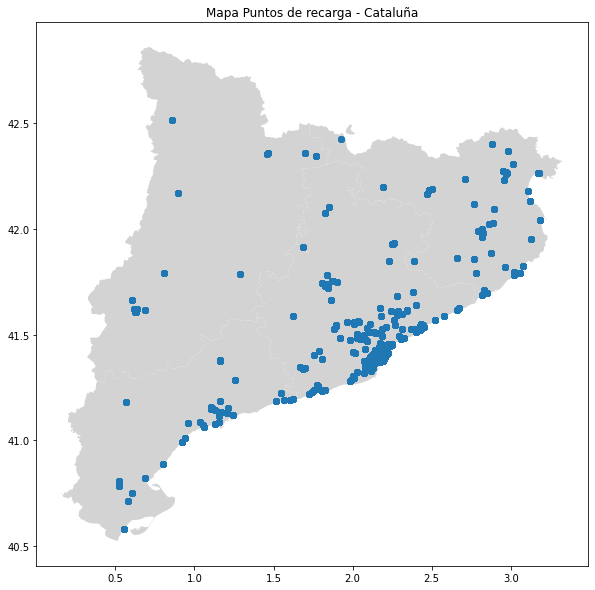

In [9]:
fig, ax = plt.subplots(figsize = (10,10))
cat_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax)
ax.set_title('Mapa Puntos de recarga - Cataluña')

Como se puede comprobar del mapa anterior, la gran mayoría de puntos se concentran en la ciudad de Barcelona y alrededores. Existen cúmulos de puntos a lo largo del territorio, principalmente ligados a las capitales de provincia (Barcelona, Gerona, Lérida y Tarragona). A continuación se representa también un mapa de calor donde se refuerzan estas conclusiones.



In [10]:
#fuente: https://stackoverflow.com/questions/37885798/how-to-calculate-the-midpoint-of-several-geolocations-in-python
import math

x = 0.0
y = 0.0
z = 0.0

for i, coord in df_grafo_desc_fin.iterrows():
    latitude = math.radians(coord.lat_ini)
    longitude = math.radians(coord.lon_ini)

    x += math.cos(latitude) * math.cos(longitude)
    y += math.cos(latitude) * math.sin(longitude)
    z += math.sin(latitude)

total = len(df_grafo_desc_fin)

x = x / total
y = y / total
z = z / total

central_longitude = math.atan2(y, x)
central_square_root = math.sqrt(x * x + y * y)
central_latitude = math.atan2(z, central_square_root)

mean_location = {
    'latitude': math.degrees(central_latitude),
    'longitude': math.degrees(central_longitude)
    }

In [11]:
mean_location

{'latitude': 41.49188277483244, 'longitude': 2.0292377982941288}

In [12]:
catalonia_map = folium.Map(location=[41.9, 1.8], zoom_start = 9) 

heatmap_data = list(map(list, zip(df_grafo_desc_fin['lat_ini'], df_grafo_desc_fin['lon_ini'])))

HeatMap(heatmap_data).add_to(catalonia_map)
#folium.vector_layers.Circle(location=[41.49188277483244, 2.0292377982941288],
 #                       radius=5,weight = 40,color='black').add_to(catalonia_map)

catalonia_map

In [13]:
#Recorrido Sur-Norte Cataluña
catalonia_map = folium.Map(location=[41.9, 1.8], zoom_start = 9) 

place_lat = [40.7124, 41.08438, 41.34179, 41.4831, 41.51058, 41.98951, 42.25973]
place_lng = [0.57921, 1.036, 1.70083, 2.05401, 2.13254, 2.79539, 2.9666]
charge = [0,0,1,0,1,1,0]

points = []
for i in range(len(place_lat)):
    points.append([place_lat[i], place_lng[i]])

for index,lat in enumerate(place_lat):
  folium.Marker([lat, 
                   place_lng[index]])
  folium.vector_layers.Circle(location=[lat,place_lng[index]],
                       radius=5,weight = 20,color='red').add_to(catalonia_map)
  if charge[index] == 1:
    folium.Marker([lat, 
                   place_lng[index]],
                 icon = folium.Icon(color='green',icon='plus')).add_to(catalonia_map)

folium.PolyLine(points, color='red').add_to(catalonia_map)

catalonia_map

In [14]:
#Recorrido Este-Oeste Cataluña
catalonia_map = folium.Map(location=[41.9, 1.8], zoom_start = 9) 

place_lat = [42.16805,41.78955,41.58935,41.73682408,42.18898,42.25973,42.26494]
place_lng = [0.89549,0.80485,1.62138,1.82836016,2.49879,2.9666,3.17073]
charge = [0,0,1,1,1,1,0]

points = []
for i in range(len(place_lat)):
    points.append([place_lat[i], place_lng[i]])

for index,lat in enumerate(place_lat):
  folium.Marker([lat, 
                   place_lng[index]])
  folium.vector_layers.Circle(location=[lat,place_lng[index]],
                       radius=5,weight = 20,color='red').add_to(catalonia_map)
  if charge[index] == 1:
    folium.Marker([lat, 
                   place_lng[index]],
                 icon = folium.Icon(color='green',icon='plus')).add_to(catalonia_map)

folium.PolyLine(points, color='red').add_to(catalonia_map)

catalonia_map

In [15]:
#Recorrido Lérida-Salou Cataluña
catalonia_map = folium.Map(location=[41.9, 1.8], zoom_start = 9) 

place_lat = [41.62044,41.37739,41.079048]
place_lng = [0.61788,1.16358,1.132352]
charge = [0,1,0]

points = []
for i in range(len(place_lat)):
    points.append([place_lat[i], place_lng[i]])

for index,lat in enumerate(place_lat):
  folium.Marker([lat, 
                   place_lng[index]])
  folium.vector_layers.Circle(location=[lat,place_lng[index]],
                       radius=5,weight = 20,color='red').add_to(catalonia_map)
  if charge[index] == 1:
    folium.Marker([lat, 
                   place_lng[index]],
                 icon = folium.Icon(color='green',icon='plus')).add_to(catalonia_map)

folium.PolyLine(points, color='red').add_to(catalonia_map)

catalonia_map

In [16]:
#Recorrido Lérida-Salou Cataluña
catalonia_map = folium.Map(location=[41.9, 1.8], zoom_start = 9) 

place_lat = [41.39537,41.560821,42.10443,42.35895,42.3556]
place_lng = [2.153832,1.961738,1.85188,1.46278,1.46035]
charge = [0,0,1,1,0]

points = []
for i in range(len(place_lat)):
    points.append([place_lat[i], place_lng[i]])

for index,lat in enumerate(place_lat):
  folium.Marker([lat, 
                   place_lng[index]])
  folium.vector_layers.Circle(location=[lat,place_lng[index]],
                       radius=5,weight = 20,color='red').add_to(catalonia_map)
  if charge[index] == 1:
    folium.Marker([lat, 
                   place_lng[index]],
                 icon = folium.Icon(color='green',icon='plus')).add_to(catalonia_map)

folium.PolyLine(points, color='red').add_to(catalonia_map)

catalonia_map

In [23]:
puntos_unicos_mapa = df_grafo_desc_fin.iloc[:, [2,14,15]].drop_duplicates()

In [28]:
m=folium.Map(location=[puntos_unicos_mapa['lat_ini'].mean(),puntos_unicos_mapa['lon_ini'].mean()],zoom_start=9)

def add_marker(row):
    if row['tipo_carg_ini']=='semiRAPID i NORMAL' or row['tipo_carg_ini'] =='semiRAPID':
      marker=folium.CircleMarker([row['lat_ini'],row['lon_ini']],radius=4,color='green',popup=row['tipo_carg_ini'])
      marker.add_to(m)

    elif row['tipo_carg_ini']=='RAPID' or row['tipo_carg_ini']=='RAPID i NORMAL' or row['tipo_carg_ini']=='RAPID i semiRAPID':
        marker=folium.CircleMarker([row['lat_ini'],row['lon_ini']],radius=4,color='blue',popup=row['tipo_carg_ini'])
        marker.add_to(m)

    elif row['tipo_carg_ini']=='superRAPID':
        marker=folium.CircleMarker([row['lat_ini'],row['lon_ini']],radius=4,color='red',popup=row['tipo_carg_ini'])
        marker.add_to(m)

puntos_unicos_mapa.apply(add_marker,axis=1)


0        None
375      None
749      None
1122     None
1494     None
         ... 
70483    None
70488    None
70492    None
70495    None
70497    None
Length: 372, dtype: object

In [29]:
m